# <center>R5.A.11 - Méthodes d'optimisation <br> TP1b - Recuit Simulé </center>


_Tom Ferragut & Thibault Godin_

_IUT de Vannes, BUT Informatique_


Les données du TP, ainsi que certaines fonctions d'affichages, proviennent du [site de Marc Lorenzi ](https://www.mpsi-camille-guerin.fr/Python/python.html)

In [2]:
import numpy as np

import random

import networkx as nx

import math
# Affichage graphique

#%matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalgèbreation

%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

from ipywidgets import interact
import ipywidgets as widgets

plt.rcParams["figure.figsize"] = [12, 12]

rng = np.random.default_rng(12345)

## Problème du voyageur de commerce (Traveling Salesperson Problem, TSP)

Le [problème du voyageur de commerce](http://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce) est un problème d'optimisation combinatoire consistant à trouver le plus court chemin passant par toutes les villes (en terme de théorie des graphes on parlerait de [circuit hamiltonien](http://en.wikipedia.org/wiki/Hamiltonian_path) de poids minimum).

Le but de ce notebook est d'attaquer ce problème (de manière approchée) à l'aide de la méthode du recuit simulé vue au TP précédent.

Le problème de décision associé au problème d'optimisation du voyageur de commerce (c'est à dire le problème "ce tour est-il de poids minimal dans le graphe ?") est NP-complet. Il peut notamment être réduit au problème du cycle Hamiltonien, qui fait partie des 21 problèmes NP-complets de Karp.



Le module de graphe `networkx` propose des heuristiques de résolution de ce problème, vous pouvez consulter [la doc](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.traveling_salesman.traveling_salesman_problem.html).

## 1 - Tour de Bretagne (historique)

Essayons de résoudre le TSP sur le graphe décrit par `villes_bzh.dat`et `routes_bzh.dat`. 
- Les données `villes_bzh.dat` contiennent un numéro de département, le nom d'une ville de ce département ainsi que ses coordonées sur la carte `france.png`. 
- Les données `routes_bzh.dat` contiennent pour chaque département, la liste des ses départements voisins (nous considérons qu'il existe une route entre deux départements voisins).

Une première étape est de ce familiariser avec ces données ainsi qu'avec le module de graphe `networkx`. Pour cela nous commençons par afficher le graphe des différentes villes de `villes_bzh.dat`.

[22, 29, 35, 44, 56]
{22: (84, 404), 29: (32, 379), 35: (126, 380), 44: (127, 329), 56: (82, 357)}
109.62522519931258


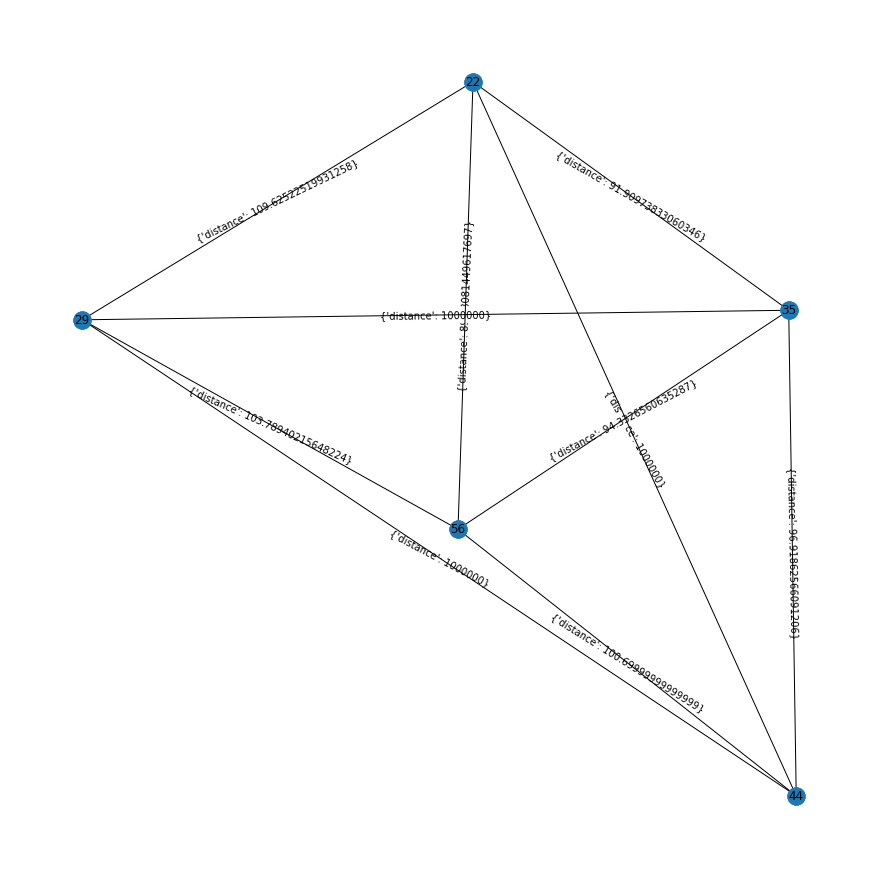

In [3]:
#lecture du fichier villes.dat


# Nombre de départements + 1
sz = 6

dept=np.array([22, 29, 35, 44, 56])


G=nx.Graph()

#Construction des sommets (nodes) du graphe G
villes = open('villes_bzh.dat')
pos={}
for i in range(1, sz):
    s = villes.readline().split(';')
    s[0]=int(s[0])
    G.add_node(s[0])

    x = int(s[2])
    y = int(s[3])
    G.nodes[s[0]]['name'] = s[1]

    G.nodes[s[0]]['position'] = (x, y)
    pos[s[0]]=(x,y)

#Affichage des sommets
nx.draw(G,pos)
print(G.nodes)


#Calcul de la distance entre deux sommets i et j    
def distance(G, i, j):
    
        (x, y) = G.nodes[i]['position']
        (a, b) = G.nodes[j]['position']
        dx = x - a
        dy = y - b
        # Conversion
        return 1.9 * math.sqrt(dx * dx + dy * dy)  
    
#Construction des arrêtes (edges) de G
routes = open('routes_bzh.dat')
for i in dept:
    s = routes.readline().split(';')
    
    #Graphe complet pour faciliter le problème 
    for j in dept:
        if i!=j and (i,j) not in G.edges:
            G.add_edges_from([(i, j, {'distance': 1000000})])
            #Cette distance choisie est arbitraire et volontairement grande.  
            #La distance est modifiée uniquement si un route correspondante existe dans route_bzh.dat.
    for j in range(1, len(s)):
        x = int(s[j])
        G.edges[i,x]['distance']=distance(G,x, i)

#Affichage des arrêtes
print(pos)
print(G.edges[29,22]['distance'])

edge_labels = nx.draw_networkx_edge_labels(G,pos = pos,)
nx.draw(G,pos = pos,with_labels=True)

>__Question 1:__ Il est commenté que nous choisissons un graphe complet pour faciliter le problème. De plus, les arrêtes ajoutées ont une longueur arbitrairement grande. Pouvez-vous trouver une explication pour ces deux choix ?

Nous affichons maintenant le graphe sur une carte de France en faisant coïncider les sommets de ce graphe G avec leur ville correspondante. 

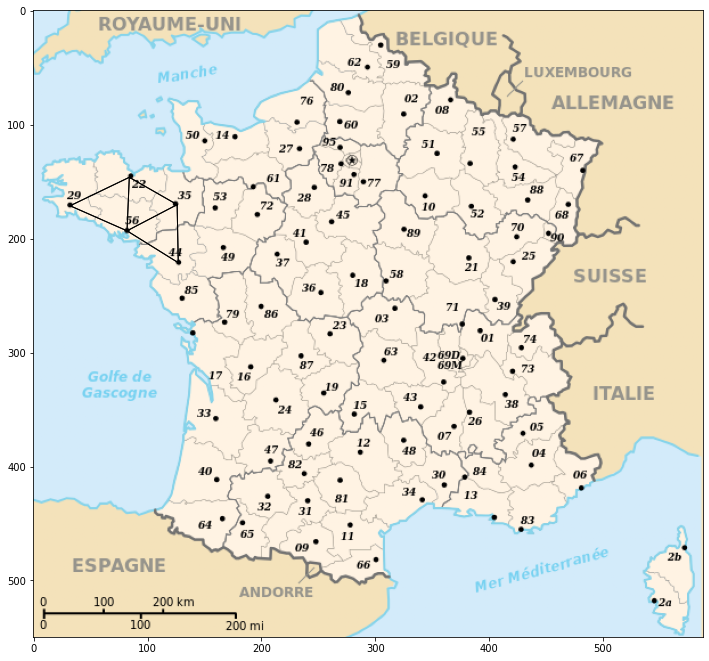

In [4]:
def afficher_carte(c=np.arange(95)+1):
    carte = mpimg.imread('france.png')
    plt.imshow(carte)
    n=len(c)
    for i in dept:
        x, y = G.nodes[i]['position']
        for j in dept:
            if i!=j:
                #La condition suivante correspond à l'existence d'une route des données route_bzh.dat (cf création des arrêtes)
                if G.edges[i,j]['distance']<1000000:
                    a, b = G.nodes[j]['position']
                    #Les arrêtes sont coloriées en bleu ou rouge lorsqu'elles font partie d'un tour du graphe
                    if c[i-1]==j or c[j-1]==i:
                        plt.plot([x, a], [550-y, 550-b], color='blue', lw=1)
                    else :
                        plt.plot([x, a], [550-y, 550-b], color='black', lw=1)
                else :
                    a, b = G.nodes[j]['position']
                    if c[i-1]==j or c[j-1]==i:
                        plt.plot([x, a], [550-y, 550-b], color='red', lw=1)
          
        
afficher_carte()

> __Question 2:__
En utilisant la fonction `afficher_carte`, affichez la carte des routes présentes dans `routes_bzh.dat` ainsi qu'un exemple de circuit du graphe complet de sommets `villes_bzh.dat`.

### Un peu de théorie : Un mot sur la représentation des permutations

Un tour (ou circuit hamiltonien) peut-être représenté par une _[permutation](https://fr.wikipedia.org/wiki/Permutation)_. Il existe deux grandes manières de représenter cet objet : par cycle ou par tableau.

La permutation $\sigma :$ $0 \to 4 $ ; $1 \to 3 $ ; $2 \to 2 $ ; $3 \to 0 $ ; $4 \to 1 $ est représentée par le tableau 

|0 |  1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- | 
|4 |  3 | 2 | 0 | 1|


mais on peut aussi le voir comme $0 \to 4 \to 1 \to 3\to 0$ ; $2\to 2$, que l'on note avec le produit de cycle
$(0,4,1,3)(2) = (0,4,1,3)$ .


Les deux notations présentent leurs avantages, et sont souvent mélangées.

Dans ce TP, on utilisera la notation en cycle pour les tours mais celle en tableau pour les calculs.

Un propriété (importante) que l'on va utiliser est que si $\sigma$ est un tour visitant toutes les villes (on dira que $\sigma$ est une ($n$-) permutation circulaire ou un ($n$-)cycle) alors $\rho^{-1}\circ \sigma \circ \rho$ l'est aussi (on dit que $\sigma$ est _conjuguée_ par $\rho$).

On va donc pouvoir choisir aléatoirement une permutation $\rho$ et conjuguer le tour initial afin d'avancer


### Retour à la pratique

Dans la suite, l'utilisation des transpositions ce fera par la fonction `transpose`. 
>__Question 3:__
Rédigez une fonction `transpose` qui étant donnée une liste d'entiers distincts `tour` et deux de ces entiers `i` et `j`, échange la position de ces deux entiers dans la liste `tour`. Vérifiez votre fonction `transpose` avec l'exemple `tour`=[0 1 2 3 4], `i`=1 et `j`=3.

In [5]:
def transpose(tour,i,j):
    
    return tour

Cette fonction `transpose` nous permet de choisir, à chaque itération de la méthode de recuit simulé, une nouvelle configuration proche aléatoire. Comme dans le TP précédent, il est temps d'écrire la fonction `energy` que l'on va minimiser par recuit simulé.

> __Question 4:__ Écrire une fonction `energy` qui, étant donné un graphe `G`, un circuit de ces sommets `tour` et une liste de département `dept`, nous renvoie une energie (que l'on veux minimale pour un circuit optimal). Tester cette fonction `energy` sur au moins deux exemples.

In [10]:
def energy(G,tour,deptlist=dept):
    ener = 0
    return ener

Il se trouve que la fonction `traveling_salesman_problem`, du module `networkx`, résout par méthode approché le Traveling Salesperson Problem. De plus, l'une des méthodes utilisées par cette fonction est une méthode de recuit simulé.


In [11]:
tour=nx.approximation.traveling_salesman_problem(G, weight='distance')
tourdept=np.array([list(dept).index(i) for i in tour])

print(tour,tourdept)


[22, 35, 44, 35, 56, 29, 22] [0 2 3 2 4 1 0]


Il nous faut maintenant implémenter la méthode de recuit simulé.

> __Question 5:__
Écrire une fonction `simulated_annealing` qui étant donné un graphe `G`, un circuit initial `initial_tour`, et des paramètres `max_iterations`, `initial_temperature` et `cooling_rate` nous renvoie un circuit d'energie optimale (au mieu) ainsi qu'une liste contenant l'évolution de l'énergie au cours des itérations.

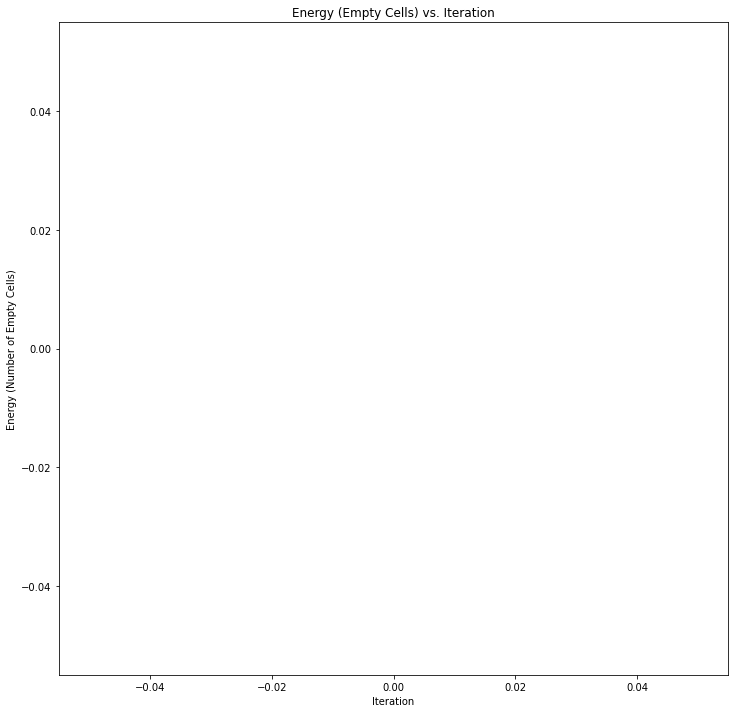

In [13]:
def simulated_annealing(G,initial_tour=[], max_iterations=100, initial_temperature=100, cooling_rate=.01):
    
    if initial_tour==[]:
        tour=np.arange(5)
        current_tour = tour
    else :
        current_tour = initial_tour

    energy_history = []  # To store energy at each iteration
   
    #initialisation of variables 

    for iteration in range(max_iterations):
        # Generate a neighboring solution using random integers and the function 'transpose'
        pass
        # Compute the difference of energy with the new configuration

        # Accept the new solution if it's better or with a certain probability

        # Cool down the temperature and store the new energy in 'energy_history' 
        
    return [current_tour, energy_history]


tour, energy_history = simulated_annealing(G,max_iterations=25)
#print(tour,energy_history[-1])
# Plot the energy history
plt.plot(range(len(energy_history)), energy_history)
plt.xlabel('Iteration')
plt.ylabel('Energy (Number of Empty Cells)')
plt.title('Energy (Empty Cells) vs. Iteration')
plt.show()

> __Question 6:__
Quelle solution de parcours optimal (du graphe G construit à partir des données `villes_bzh.dat` et `routes_bzh.dat`) la fonction `simulated_annealing` renvoie-t-elle ? Comparez cette solution à celle obtenue en utilisant la fonction `traveling_salesman_problem` de `networkx`.

## 2 - Tour de l'ouest (atlantique)

Dans cette partie nous répondons aux mêmes questions, mais avec comme données l'ensemble des départements de la façade atlantique. Essayons de résoudre le TSP sur le graphe décrit par `villes_ouest.dat`et `routes_ouest.dat`.

{16: (191, 237), 17: (140, 266), 19: (256, 214), 22: (84, 404), 23: (260, 265), 24: (213, 209), 29: (32, 379), 33: (160, 192), 35: (126, 380), 40: (162, 137), 44: (127, 329), 47: (208, 155), 49: (167, 342), 53: (159, 377), 56: (82, 357), 64: (167, 103), 72: (195, 371), 79: (168, 277), 85: (131, 296), 86: (199, 290), 87: (234, 246)}


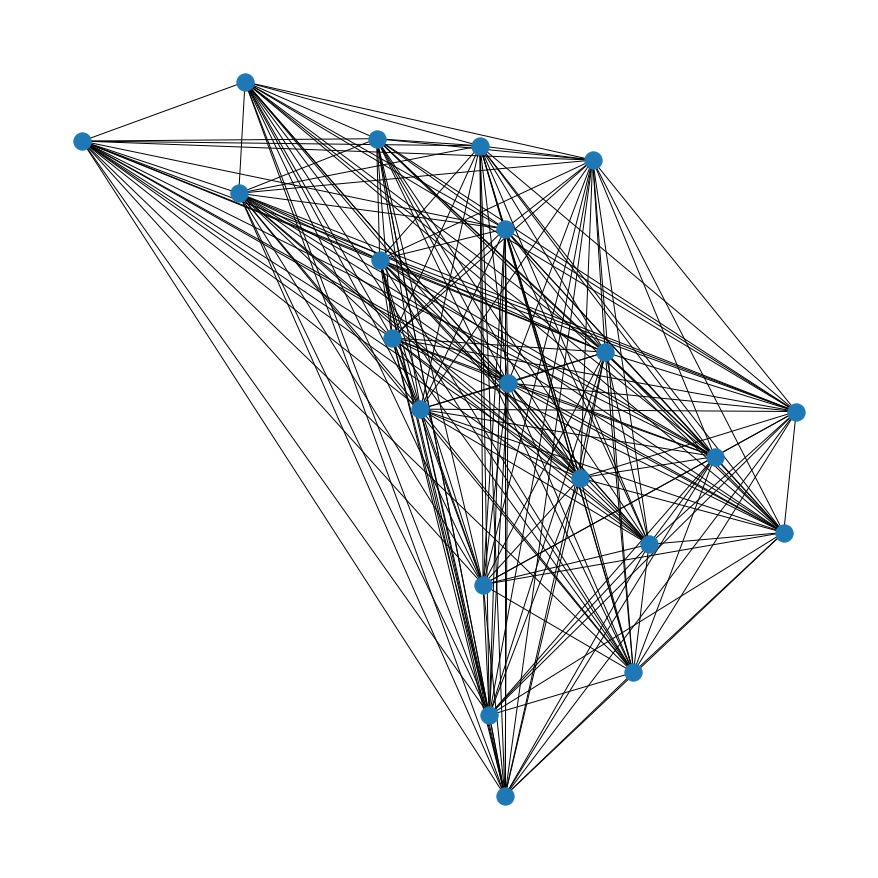

In [27]:
#lecture du fichier villes_ouest.dat

dept=np.array([16,17,19,22,23,24,29,33,35,40,44,47,49,53,56,64,72,79,85,86,87])

# Nombre de départements + 1
sz = 22

G=nx.Graph()

#nodes
villes = open('villes_ouest.dat')
pos={}
for i in range(1, sz):
    s = villes.readline().split(';')
    s[0] = int(s[0])
    G.add_node(s[0])

    x = int(s[2])
    y = int(s[3])
    G.nodes[s[0]]['name'] = s[1]

    G.nodes[s[0]]['position'] = (x, y)
    pos[s[0]]=(x,y)


def distance(G, i, j):
        (x, y) = G.nodes[i]['position']
        (a, b) = G.nodes[j]['position']
        dx = x - a
        dy = y - b
        return 1.9 * math.sqrt(dx * dx + dy * dy)
        
    
#edges
routes = open('routes_ouest.dat')
for i in dept:
    s = routes.readline().split(';')
    
    #Graphe complet pour faciliter le problème 
    for j in dept:
        if i!=j and (i,j) not in G.edges:
            G.add_edges_from([(i, j, {'distance': 1000000})])
            #Cette distance choisie est arbitraire et volontairement grande.  
            #La distance est modifiée uniquement si un route correspondante existe dans route_bzh.dat.
    for j in range(1, len(s)):
        x = int(s[j])
        G.edges[i,x]['distance']=distance(G,x, i)

print(pos)    
nx.draw(G,pos = pos)

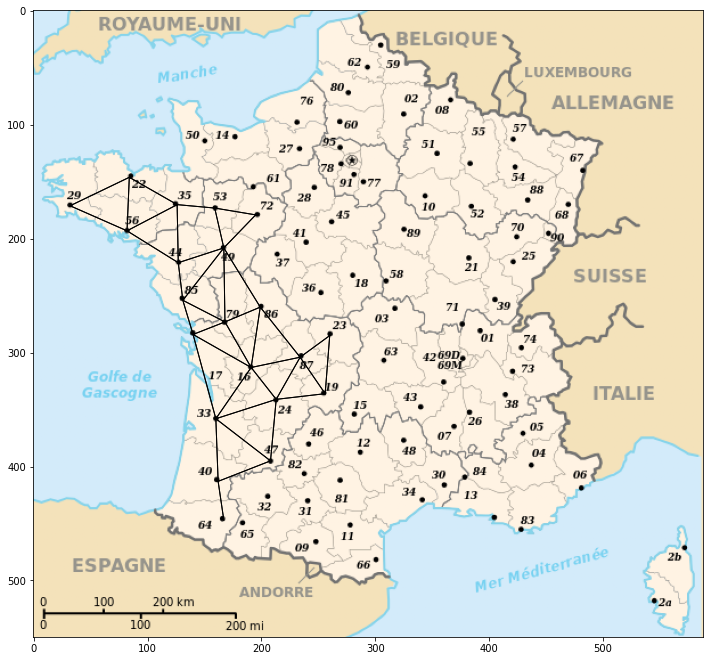

In [28]:
afficher_carte()

>__Question 7:__ Que peut-on prendre comme configuration initiale de circuit ? 

>__Question 8:__ 
Répondre aux questions __2__ et __6__ en remplaçant les données `villes_bzh.dat` (respectivement `routes_bzh.dat`) par `villes_ouest.dat` (resp. `routes_ouest.dat`).

## 3 - Tour de France (métropolitaine)

Dans cette partie nous répondons aux mêmes questions, mais avec comme données l'ensemble des départements de la France métropolitaine. Essayons de résoudre le TSP sur le graphe décrit par `villes.dat`et `routes.dat`.

In [ ]:
#lecture du fichier villes.dat


# Nombre de départements + 1
sz = 96

G=nx.Graph()

#nodes
villes = open('villes.dat')
pos={}
for i in range(1, sz):
    s = villes.readline().split(';')
    s[0]=int(s[0])
    G.add_node(s[0])

    x = int(s[2])
    y = int(s[3])
    G.nodes[s[0]]['name'] = s[1]

    G.nodes[s[0]]['position'] = (x, y)
    pos[s[0]]=(x,y)


def distance(G, i, j):
        (x, y) = G.nodes[i]['position']
        (a, b) = G.nodes[j]['position']
        dx = x - a
        dy = y - b
        return 1.9 * math.sqrt(dx * dx + dy * dy)
        
    
#edges
routes = open('routes.dat')
for i in range(1, sz):
    s = routes.readline().split(';')
    #graphe complet pour faciliter le problème 
    for j in range(1, sz):
        if i!=j:
            G.add_edges_from([(i, j, {'distance': 1000000})])
    for j in range(1, len(s)):
        x = int(s[j])
        G.edges[i,x]['distance']=distance(G,x, i)

print(pos)    
nx.draw(G,pos = pos)

>__Question 9:__ 
Répondre aux questions __2__ et __6__ en remplaçant les données `villes_bzh.dat` (respectivement `routes_bzh.dat`) par `villes.dat` (resp. `routes.dat`).
Que constatez vous ?